
# Proyek Akhir : Klasifikasi Gambar
## Nama : Iqbal Al Hafidzu Rahman

### Penggunaan Library

Disini saya menggunakan framework tensorflow

In [ ]:
import os
import cv2
import random
import shutil
import imutils
import tensorflow as tf
import tkinter as tk
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing import image
from google.colab import files
from google.colab import drive

In [ ]:
# Path Dataset

drive.mount('/content/drive')
dataset_folder = '/content/drive/MyDrive/IDCamp/rockpaperscissors/'
output_folder = '/content/drive/MyDrive/IDCamp/newdataset/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Image Pre-Processing

Karena data-data pada dataset ini sangat homogen, maka disini saya akan melakukan pre-processing untuk meminimalisir terjadinya overfitting pada model

In [ ]:
def pre_processing():

    for folder in [output_folder, os.path.join(output_folder, 'training'), os.path.join(output_folder, 'validation')]:
        if not os.path.exists(folder):
            os.makedirs(folder)

    # Parameter untuk ukuran dataset validation
    validation_split = 0.4

    def apply_augmentation(image):

        if random.random() < 0.5:
            # Flip gambar secara horizontal
            image = cv2.flip(image, 1)

        if random.random() < 0.5:
            # Menaikkan dan menurunkan kecerahan
            alpha = random.uniform(0.7, 1.3)
            image = cv2.multiply(image, np.array([alpha]))

        if random.random() < 0.5:
            # Menaikkan dan menurunkan kontras
            alpha = random.uniform(0.7, 1.3)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            gray = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
            image = cv2.addWeighted(image, alpha, gray, 1 - alpha, 0)

        if random.random() < 0.5:
            # Merubah kecerahan dan kontras secara acak
            alpha = random.uniform(0.7, 1.3)
            image = cv2.multiply(image, np.array([alpha]))

            alpha = random.uniform(0.7, 1.3)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            gray = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
            image = cv2.addWeighted(image, alpha, gray, 1 - alpha, 0)

        if random.random() < 0.5:
            # Rotasi 90 derajat
            image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)

        return image


    for class_name in os.listdir(dataset_folder):
        class_folder = os.path.join(dataset_folder, class_name)

        training_class_folder = os.path.join(output_folder, 'training', class_name)
        validation_class_folder = os.path.join(output_folder, 'validation', class_name)
        for folder in [training_class_folder, validation_class_folder]:
            if not os.path.exists(folder):
                os.makedirs(folder)

        image_files = os.listdir(class_folder)
        random.shuffle(image_files)
        num_validation_images = int(len(image_files) * validation_split)

        for i, image_name in enumerate(image_files):
            image_path = os.path.join(class_folder, image_name)

            if i < num_validation_images:
                output_image_path = os.path.join(validation_class_folder, image_name)
            else:
                output_image_path = os.path.join(training_class_folder, image_name)

            image = cv2.imread(image_path)
            image = apply_augmentation(image)
            cv2.imwrite(output_image_path, image)

In [ ]:
# pre_processing()

In [ ]:
train_folder = '/content/drive/MyDrive/IDCamp/newdataset/training'
val_folder = '/content/drive/MyDrive/IDCamp/newdataset/validation'

### Data Generator dan Augmentasi Gambar
Lalu disini saya menggunakan image data generator dan mengimplementasikan augmentasi data

In [ ]:
# Data Generator dan Augmentasi Gambar
data_gen = ImageDataGenerator(rescale=1/255,
                              rotation_range=40,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              shear_range=0.2,
                              zoom_range=0.2,
                              horizontal_flip=True,
                              fill_mode='nearest')

train_dataset = data_gen.flow_from_directory(train_folder, (128, 128), class_mode="sparse")
validation_dataset = data_gen.flow_from_directory(val_folder, (128, 128), class_mode="sparse")

Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


### Model
Disini saya menggunakan model sequential dengan arsitektur jaringan yang saya bangun sendiri, yang mengutamakan akurasi serta meminimalisir beban komputasi dan waktu training

In [ ]:
# Pembuatan Model
model = Sequential()

# Convolutional layer 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(2, 2))

# Convolutional layer 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

# Convolutional layer 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

# Flatten Layer
model.add(Flatten())

# Fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
# Dropout untuk mengurangi overfitting
model.add(Dropout(0.02))
model.add(Dense(train_dataset.num_classes, activation='softmax'))

# Summary dari model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

In [ ]:
# Proses Compile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Callback
disini saya menggunakan checkpoint callback yang akan melakukan early stop dengan acuan validation loss dan akan merestorasi weight terbaik agar tidak terjadi overfitting pada model dan tidak melakukan training yang sudah tidak optimal untuk menghemat waktu

In [ ]:
# Membuat callback untuk model
checkpoint_filepath = '/content/drive/MyDrive/IDCamp/checkpoint'

# checkpoint
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# early stop
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True)

In [ ]:
# Model fitting
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=validation_dataset,
                    callbacks=[early_stop, model_checkpoint])

model.save('/content/drive/MyDrive/IDCamp/Model')

Epoch 1/10
42/42 [==============================] - 88s 2s/step - loss: 0.5160 - accuracy: 0.7892 - val_loss: 0.4474 - val_accuracy: 0.8501
Epoch 2/10
42/42 [==============================] - 96s 2s/step - loss: 0.4941 - accuracy: 0.7907 - val_loss: 0.4122 - val_accuracy: 0.8513
Epoch 3/10
42/42 [==============================] - 81s 2s/step - loss: 0.4172 - accuracy: 0.8349 - val_loss: 0.4526 - val_accuracy: 0.8398
Epoch 4/10
42/42 [==============================] - 85s 2s/step - loss: 0.3044 - accuracy: 0.8927 - val_loss: 0.2918 - val_accuracy: 0.9119
Epoch 5/10
42/42 [==============================] - 85s 2s/step - loss: 0.3223 - accuracy: 0.8843 - val_loss: 0.2833 - val_accuracy: 0.9142
Epoch 6/10
42/42 [==============================] - 85s 2s/step - loss: 0.2812 - accuracy: 0.9049 - val_loss: 0.2979 - val_accuracy: 0.8993
Epoch 7/10
42/42 [==============================] - 88s 2s/step - loss: 0.2976 - accuracy: 0.8858 - val_loss: 0.2613 - val_accuracy: 0.9039
Epoch 8/10
42/42 [==

In [ ]:
# Load model
loaded_model = load_model('/content/drive/MyDrive/IDCamp/Model')
class_names = ["Paper", "Rock", "Scissor"]

### Prediksi gambar
Disini model akan memprediksi gambar yang dimasukkan oleh user

Saving bdO9pxWWsTRxmT2z.png to bdO9pxWWsTRxmT2z.png
1/1 [==============================] - 0s 35ms/step
Predicted Class: Rock


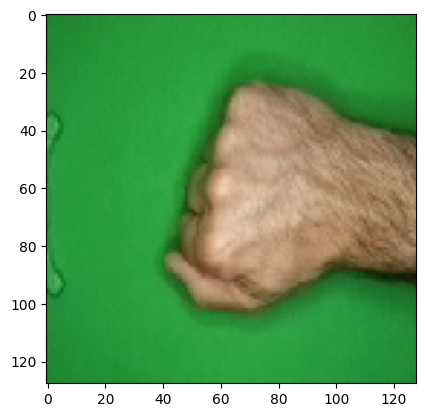

In [ ]:
image_upload = files.upload()

for fn in image_upload.keys():
  path = fn
  img = image.load_img(path, target_size = (128, 128))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  img = np.vstack([x])

prediction =loaded_model.predict(img)
class_index = np.argmax(prediction)
class_name = class_names[class_index]
print(f"Predicted Class: {class_name}")